# **Pretraining an LLM on Unlabeled Data**

In [1]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        "tensorflow" # For OpenAI's pretrained weights since earlier models were trained in TensorFlow
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.1
numpy version: 2.2.5
tiktoken version: 0.9.0
torch version: 2.7.0
tensorflow version: 2.19.0


This notebook covers the following topics in addition to covering a basic training loop for an introduction to model evaluations during LLM pretraining.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/mental-model--0.webp" width=400px>

## **1. Evaluating Generative Text Models**

Let's begin by setting up the LLM's configuration from previous notebooks. We will be retaining the original context length since we have access to a reasonable consumer grade GPU which should easily handle `context_length: 1024`. This is the same configuration as the original GPT-2 model with 124 million parameters.

`text_to_token_ids()` and `token_ids_to_text()` are functions which facilitate the conversion between text and token representations. Additionally, it is important to note that modern LLMs **do not** use a dropout rate as well as bias vectors. The dropout rate below reflects the settings used to train the original GPT-2 model.

In [ ]:
import torch
from utils.components import GPTModel

# GPT configuration from previos NBs
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Retaining original context length
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate 
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(42)
model = GPTModel(GPT_CONFIG_124M)
model.eval(); # Dropout disabled during inference

`NOTE` Experiment with context lengths and embedding dimensions to generate longer sequences from larger text files 

In [3]:
import tiktoken
from utils.components import generate_text_simple

# Pipeline functions
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # Add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # Removing batch dim
    return tokenizer.decode(flat.tolist())

start_context = "In the grim darkness of the far future"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 In the grim darkness of the far futurerotto defundFurthermore Levinealways� Cam vaguely unearthed


The generated text is gibberish since the model hasn't been trained yet. We will also be evaluating the quality of text generation in sections below.

### **1.1 Calculating The Text Generation Loss i.e. Cross-Entropy and Perplexity**

For demonstration purposes, we will create two inputs of three tokens each and will then compute vectors containing the probability scores corresponding to each token in the vocabulary. The index of the highest probability score in each vector represents the most likely next token ID which is then returned to generate the required text.

In [4]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [5]:
with torch.no_grad():
    logits = model(inputs)
    
probs = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probs.shape) # Shape ==> (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


In [6]:
token_ids = torch.argmax(probs, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[24851],
         [  406],
         [40115]],

        [[29716],
         [40825],
         [19647]]])


In [7]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1: etti L HO


The output tokens don't match the target tokens we created above - as expected. But we also want to know how far the generated tokens are from the correct predictions. 

In [8]:
# Token probabilities corresponding to the target indices
text_idx = 0
target_probs_1 = probs[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probs_1)

text_idx = 1
target_probs_2 = probs[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probs_2)

Text 1: tensor([4.3173e-06, 2.1993e-05, 1.0362e-05])
Text 1: tensor([1.2699e-05, 2.9482e-05, 6.5255e-06])


In [9]:
# Compute log of all token probabilities
log_probs = torch.log(torch.cat((target_probs_1, target_probs_2)))
print(log_probs)

tensor([-12.3529, -10.7248, -11.4774, -11.2740, -10.4317, -11.9398])


In [10]:
# Computing the average log probability of each token
avg_log_probs = torch.mean(log_probs)
print(avg_log_probs)

tensor(-11.3668)


>- The goal is to make this average log probability as large as possible by optimizing the model weights
>- Due to the log, the largest possible value is 0, and we are currently far away from 0
>- In deep learning, instead of maximizing the average log-probability, it's a standard convention to minimize the *negative* average log-probability value.

**`CROSS ENTROPY`** This measures the difference between two probability distributions - which in this case are the true distributions of the labels and the predicted distributions from the model i.e. the token probabilities generated by the LLM. PyTorch uses the cross-entropy function for discrete outcomes which _is similar to negative average log probability of the target tokens given the model's generated token probabilities_, thus making the two terms interchangeable.

In [11]:
# Minimize the negative average log-probability
neg_avg_log_prob = avg_log_probs * -1
print(neg_avg_log_prob)

tensor(11.3668)


In [12]:
# Prior to implementing cross entropy, we should check the shape of logits and targets
# Logits shape --> (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [13]:
# Flattening above tensors for cross entropy. Flattening is done by combining over the batch dimension
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

# Applying cross entropy loss
# Previously we, applied the softmax function, selected probability scores corresponding to target ids and
# computed the negative average log probabilities. Cross Entropy handles all of these steps.
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)

# Printing shapes and cross entropy loss
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)
print("Cross-Entropy loss:", loss)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])
Cross-Entropy loss: tensor(11.3668)


In [14]:
torch.nn.functional.cross_entropy?

Signature:
torch.nn.functional.cross_entropy(
    input: torch.Tensor,
    target: torch.Tensor,
    weight: Optional[torch.Tensor] = None,
    size_average: Optional[bool] = None,
    ignore_index: int = -100,
    reduce: Optional[bool] = None,
    reduction: str = 'mean',
    label_smoothing: float = 0.0,
) -> torch.Tensor
Docstring:
Compute the cross entropy loss between input logits and target.

See :class:`~torch.nn.CrossEntropyLoss` for details.

Args:
    input (Tensor) : Predicted unnormalized logits;
        see Shape section below for supported shapes.
    target (Tensor) : Ground truth class indices or class probabilities;
        see Shape section below for supported shapes.
    weight (Tensor, optional): a manual rescaling weight given to each
        class. If given, has to be a Tensor of size `C`
    size_average (bool, optional): Deprecated (see :attr:`reduction`). By default,
        the losses are averaged over each loss element in the batch. Note that for
        som

**`Perplexity`** This is a measure used in conjuction with cross entropy loss to evaluate the performance of models in tasks like language modeling. It can provide a more interpretable way to understand the uncertainty of a model in predicting the next sequence. Specifically, it measures how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset. Lower perplexity indcates that the model predictions are closed to the actual distribution.

This measure is often considered to be more interpretable than the raw loss value because it signifies the effective vocabulary size that the model is _unsure_ of.

In [15]:
# Calculating the perplexity 
perplexity = torch.exp(loss)
print("Perplexity:", perplexity)

Perplexity: tensor(86402.1562)


### **1.2 Calculating Training and Validation Losses** 

In [16]:
import os

# Loading sample training text.
#file_path = "data/the-law-bastiat.txt"
file_path = "data/the-verdict.txt"

with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [17]:
# First and last99 chars
print(text_data[:99], "\n")
print(text_data[-99:])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no  

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [18]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters: ", total_characters)
print("Tokens: ", total_tokens)

Characters:  20479
Tokens:  5145


Here, we will be training our model with training data presented in similarly sized chunks for simplicity and efficiency. In practice, it can also be beneficial to train an LLM with variable-length inputs to help it to better generalize across different types of inputs when it is being used.

In [19]:
from utils.components import create_dataloader_v1

# Training / validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

torch.manual_seed(42)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [20]:
# Running sanity check
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader!")
    
if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader!")

In [21]:
# Checking shapes of train and val loaders.
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [22]:
# Checking token sizes
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()
    
val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [23]:
# Function to calculate the loss of a single batch
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

# Calculate the loss over all batches sampled by a given data loader.
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce num of batches to match the total number of batches in the data loader
        # in case values are exceeded.
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else: 
            break
    return total_loss / num_batches

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

torch.manual_seed(42)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
    
print("Training loss:", train_loss)
print("Validation loss:", val_loss)  

Training loss: 11.003963894314236
Validation loss: 11.044095039367676


## Training an LLM

In [25]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, 
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    
    # Main training loop
    for epoch in range(num_epochs):
        model.train()
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1
            
            # Additional eval step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
                
        # Print sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context)
        
    return train_losses, val_losses, track_tokens_seen
    

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
        model.eval()
        context_size = model.pos_emb.weight.shape[0]
        encoded = text_to_token_ids(start_context, tokenizer).to(device)
        with torch.no_grad():
            token_ids = generate_text_simple(
                model=model, idx=encoded,
                max_new_tokens=50, context_size=context_size
                )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " ")) # Compact print format
        model.train()        

In [25]:
torch.cuda.empty_cache()

In [26]:
import time
start_time = time.time()

torch.manual_seed(42)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="In the grim darkness of the far future", tokenizer=tokenizer
)

end_time = time.time()
execution_time = (end_time - start_time) / 60
print(f"Training completed in {execution_time:.2f} mins.")

Epoch 1 (Step 000000): Train loss 10.032, Val loss 10.127
Epoch 1 (Step 000005): Train loss 8.172, Val loss 8.353
In the grim darkness of the far future,                                                 
Epoch 2 (Step 000010): Train loss 6.796, Val loss 7.099
Epoch 2 (Step 000015): Train loss 6.064, Val loss 6.640
In the grim darkness of the far future, the, the, the, the, the, the, the, the, the, the, the                            
Epoch 3 (Step 000020): Train loss 5.668, Val loss 6.606
Epoch 3 (Step 000025): Train loss 5.292, Val loss 6.571
In the grim darkness of the far future aburn had a he had aII. Gisburn had a I had a in theI had a him, and I had a it was a I had theI had theI. Gisburn had theI to see it was
Epoch 4 (Step 000030): Train loss 5.211, Val loss 6.418
Epoch 4 (Step 000035): Train loss 4.470, Val loss 6.382
In the grim darkness of the far future--and I had a felt, and I had been                                       
Epoch 5 (Step 000040): Train loss 3.923, Val loss 

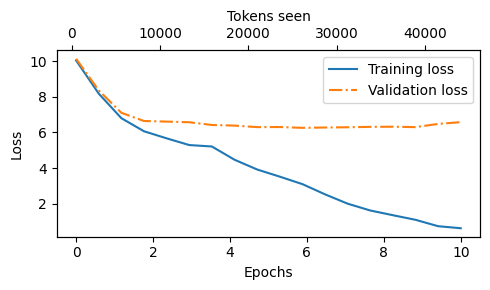

In [27]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    #plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)